In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

import numpy as np
import matplotlib.pyplot as plt

# Exercise 5: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or even directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size and model robustness

In [2]:
for i in range(1600, 1701):
        print(f"Trying to import Exercise5_Handout.{i:06d}")


Trying to import Exercise5_Handout.001600
Trying to import Exercise5_Handout.001601
Trying to import Exercise5_Handout.001602
Trying to import Exercise5_Handout.001603
Trying to import Exercise5_Handout.001604
Trying to import Exercise5_Handout.001605
Trying to import Exercise5_Handout.001606
Trying to import Exercise5_Handout.001607
Trying to import Exercise5_Handout.001608
Trying to import Exercise5_Handout.001609
Trying to import Exercise5_Handout.001610
Trying to import Exercise5_Handout.001611
Trying to import Exercise5_Handout.001612
Trying to import Exercise5_Handout.001613
Trying to import Exercise5_Handout.001614
Trying to import Exercise5_Handout.001615
Trying to import Exercise5_Handout.001616
Trying to import Exercise5_Handout.001617
Trying to import Exercise5_Handout.001618
Trying to import Exercise5_Handout.001619
Trying to import Exercise5_Handout.001620
Trying to import Exercise5_Handout.001621
Trying to import Exercise5_Handout.001622
Trying to import Exercise5_Handout

In [52]:
class OurDataset(Dataset):
    def __init__(self, groundtruths, images):
        """
        groundtruth_root: Path to the directory containing ground truth images.
        input_root: Path to the directory containing input images.
        """
        self.labels = groundtruths
        self.data = images
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]  # Input image (PIL or file path)
        y = self.labels[idx]  # Ground truth (PIL or file path)

        # Apply transformations
        x = self.transform(x)  
        y = self.transform(y)  
        y = (y > 0.5).long().squeeze(0)  # Convert ground truth to binary mask

        return x, y

In [53]:
data_root = "highway"
groundtruth_root = data_root + "/groundtruth"
input_root = data_root + "/input"

groundtruths = [Image.open(f"{groundtruth_root}/gt{i:06d}.png") for i in range(470, 1701)]
images = [Image.open(f"{input_root}/in{i:06d}.jpg") for i in range(470, 1701)]

In [54]:
dataset = OurDataset(groundtruths, images)

Unique values in ground truth: [0 1]


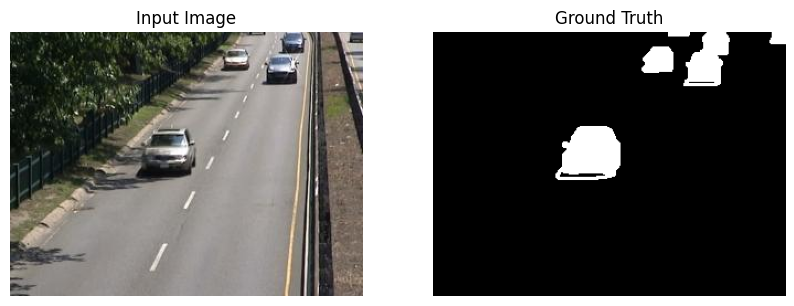

In [55]:
input_image, ground_truth = dataset[510]

input_image_np = input_image.permute(1, 2, 0).numpy() # -> H, W , 3
ground_truth_np = ground_truth.squeeze(0).numpy() 

unique_vals_gt = np.unique(ground_truth_np)
print(f"Unique values in ground truth: {unique_vals_gt}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_np, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.show()

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

In [56]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # If ch count changes
        self.proj = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.proj(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        return self.relu(out)
    
class ResidualUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super().__init__()
        
        # encoder
        self.enc0 = ResidualBlock(3, 32)
        self.enc1 = ResidualBlock(32, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck = ResidualBlock(256, 512)

        # deocder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        self.up0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  
        self.dec0 = ResidualBlock(64, 32)

        # segmentation head
        self.segmentation_head = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(self.pool(enc0))
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        bottleneck = self.bottleneck(self.pool(enc3))
        
        dec3 = self.dec3(torch.cat([self.up3(bottleneck), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))
        dec0 = self.dec0(torch.cat([self.up0(dec1), enc0], dim=1))

        # Segmentation head
        return self.segmentation_head(dec0)
        
        # Note: cat()  concatenates the two tensors along dimension 1 in this case:
        # Example: 
        # x    : (B, C1, H, W)   
        # skip : (B, C2, H, W) 
        # -----------------------------------------------
        # result: (B, C1 + C2, H, W)

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

In [57]:
import random

ratio = 0.8

amount = len(dataset)

print(f"Length of dataset: {amount}")

random.seed(42)
train_indices = random.sample(range(amount), round(amount * ratio))
test_indices = list(set(range(amount)) - set(train_indices))
print(train_indices)    
print(test_indices)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Length of dataset: 1231
[228, 51, 563, 501, 457, 285, 209, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 54, 1149, 407, 1223, 859, 451, 919, 1206, 569, 13, 326, 865, 696, 1205, 318, 440, 689, 1224, 189, 778, 198, 735, 704, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 740, 393, 142, 93, 466, 592, 163, 1215, 206, 1194, 1200, 928, 747, 333, 758, 727, 429, 546, 146, 350, 1093, 1227, 334, 946, 777, 552, 1140, 449, 664, 114, 469, 1219, 646, 821, 548, 135, 432, 644, 435, 1022, 810, 939, 292, 542, 1225, 505, 1103, 538, 877, 817, 741, 1154, 283, 1043, 1010, 186, 96, 224, 313, 327, 1220, 130, 788, 781, 958, 1083, 514, 23, 234, 1099, 1164, 1201, 1230, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 611, 1100, 1211, 1123, 765, 330, 1086, 1, 663, 1000, 39, 229, 743, 629, 490, 118, 493, 1184, 175, 995, 141, 257, 262, 973, 338, 1138, 866, 433, 411, 638, 1132, 764, 897, 1059, 924, 247, 507, 460, 131, 692, 43, 471, 1208, 14, 145, 120, 468, 138, 64, 676, 1054, 487, 570, 994, 438, 270, 968, 497, 

In [58]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [87]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    train_losses = []
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, labels.squeeze(1).long())
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item()) # Logging

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss, train_losses

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    validation_losses = []
    accuracies, precisions, recalls, ious = [], [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels.squeeze(1).long())
            validation_losses.append(loss.item())
        
            preds = torch.argmax(outputs, dim=1)

            # evaluation metrics per image:
            for i in range(len(images)):
                pred = preds[i].cpu().numpy().flatten()
                label = labels[i].cpu().numpy().flatten()

                accuracy = accuracy_score(label, pred)
                precision = precision_score(label, pred, zero_division=0)
                recall = recall_score(label, pred, zero_division=0)
                iou = jaccard_score(label, pred, zero_division=0)

                accuracies.append(accuracy)
                precisions.append(precision)
                recalls.append(recall)
                ious.append(iou)
            
    return validation_losses, accuracies, precisions, recalls, ious


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualUnet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [89]:
num_epochs = 10
train_losses, validation_losses = [], []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    avg_train_loss, t_losses = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    
    v_losses, accuracies, precisions, recalls, ious = validate(model, test_loader, loss_fn, device)

    train_losses.append(t_losses)
    validation_losses.append(v_losses)

    print(f"    Average Training Loss: {avg_train_loss:.4f}")
    print(f"    Average Accuracy: {np.mean(accuracies):.4f}, Average Precision: {np.mean(precisions):.4f}, Average Recall: {np.mean(recalls):.4f}, Average IoU: {np.mean(ious):.4f}")

Epoch 1/10
    Average Training Loss: 0.3459
    Average Accuracy: 0.9885, Average Precision: 0.9815, Average Recall: 0.8609, Average IoU: 0.8468
Epoch 2/10
    Average Training Loss: 0.0340
    Average Accuracy: 0.9940, Average Precision: 0.9671, Average Recall: 0.9528, Average IoU: 0.9229
Epoch 3/10
    Average Training Loss: 0.0162
    Average Accuracy: 0.9946, Average Precision: 0.9744, Average Recall: 0.9556, Average IoU: 0.9321
Epoch 4/10
    Average Training Loss: 0.0125
    Average Accuracy: 0.9953, Average Precision: 0.9750, Average Recall: 0.9644, Average IoU: 0.9411
Epoch 5/10
    Average Training Loss: 0.0109
    Average Accuracy: 0.9959, Average Precision: 0.9706, Average Recall: 0.9773, Average IoU: 0.9492
Epoch 6/10
    Average Training Loss: 0.0095
    Average Accuracy: 0.9956, Average Precision: 0.9620, Average Recall: 0.9818, Average IoU: 0.9451
Epoch 7/10
    Average Training Loss: 0.0095
    Average Accuracy: 0.9960, Average Precision: 0.9775, Average Recall: 0.9724

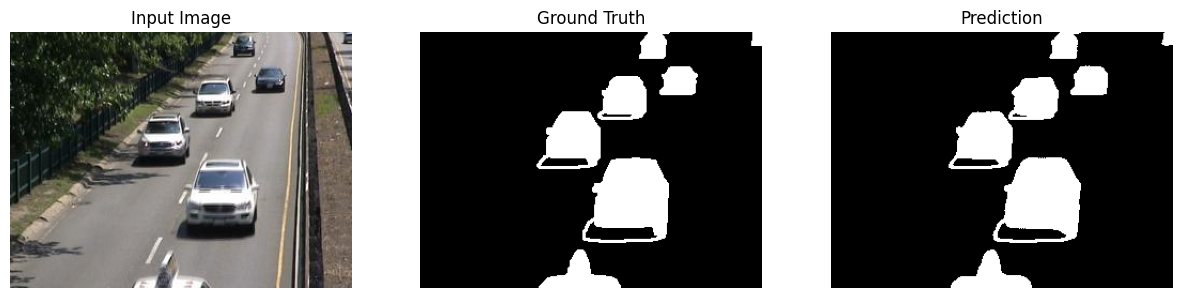

In [90]:
# Visualization of prediction vs groundtruth

input_image, ground_truth = test_dataset[100]

input_image_np = input_image.permute(1, 2, 0).numpy() # -> H, W , 3
ground_truth_np = ground_truth.squeeze(0).numpy() 
model.eval()
with torch.no_grad():
    input_image = input_image.unsqueeze(0).to(device)
    output = model(input_image)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

plt.figure(figsize=(15, 5))  # Adjust figure size for 3 subplots

# img
plt.subplot(1, 3, 1)
plt.imshow(input_image_np)
plt.title("Input Image")
plt.axis("off")

# gt
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_np, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# pred
plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.show()

## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model

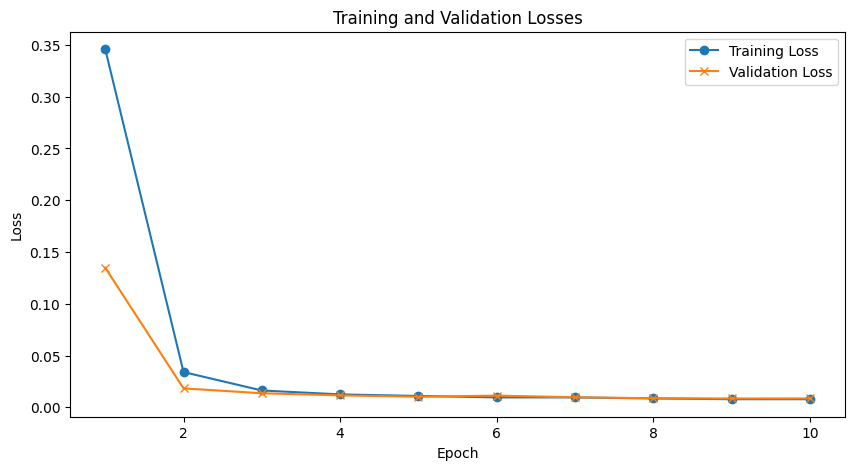

In [91]:
# plot train_losses and validation_losses
train_losses_per_epoch = [np.mean(epoch_losses) for epoch_losses in train_losses]
validation_losses_per_epoch = [np.mean(epoch_losses) for epoch_losses in validation_losses]

plt.figure(figsize=(10, 5))
plt.plot(range(1,num_epochs+1), train_losses_per_epoch, label="Training Loss", marker='o')
plt.plot(range(1,num_epochs+1), validation_losses_per_epoch, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

In [85]:
_, accuracy, accuracies, precisions, recalls, ious = validate(model, test_loader, loss_fn, device)

print(f"    Average Accuracy: {np.mean(accuracies):.4f}, Average Precision: {np.mean(precisions):.4f}, Average Recall: {np.mean(recalls):.4f}, Average IoU: {np.mean(ious):.4f}")

    Average Accuracy: 0.9966, Average Precision: 0.9717, Average Recall: 0.9858, Average IoU: 0.9583
